In [1]:
from watclaimdata import test_df,train_df,valid_df

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

2023-10-23 01:08:14.468611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df.tail()

,claim,id,rating,original_rating
26971,"If an individual is determined ""to commit suic...",26972,1,barely-true
26972,Former NBA star said modern basketball players...,26973,0,false
26973,"""Since Debbie Halvorson has been in politics, ...",26974,1,half-true
26974,"President Barack Obama ""had the legal authorit...",26975,2,true
26975,Photograph of a Congress worker protesting aga...,26976,0,false


<AxesSubplot:>

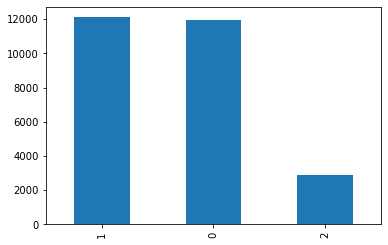

In [3]:
train_df['rating'].value_counts().plot(kind='bar')

In [4]:
# check version number
import imblearn
print(imblearn.__version__)

0.9.0


NearMiss-3 selects the closest examples from the majority class for each minority class.

The n_neighbors_ver3 argument determines the number of examples to select for each minority example, although the desired balancing ratio set via sampling_strategy will filter this to achieve the desired balance.

In [5]:
X = train_df.iloc[:,1:2]
X.shape

(26976, 1)

In [6]:
y = train_df['rating']
y.shape

(26976,)

In [7]:
valid_df['indx'] = valid_df.index

In [8]:
valid_df.head()

,claim,id,rating,original_rating,indx
0,"Video shows that ""Joe Biden participated in 'B...",26977,0,false,0
1,"""While Act 10 allowed (Milwaukee County) to sa...",26978,1,half-true,1
2,"""In Massachusetts, Biden’s vote exceeded exit ...",26979,0,false,2
3,Reliance supplying Jio Atta after farm bills w...,26980,0,false,3
4,Photo of maulvi and MP Shafiqur Rahman Virk pe...,26981,0,false,4


In [9]:
X_v = valid_df[['indx']]
y_v = valid_df['rating']
X_v.shape

(3372, 1)

In [10]:
# define the undersampling method
# undersample = NearMiss(version=3)

from imblearn.over_sampling import SMOTE


# define the undersampling method
oversample = SMOTE()
# transform the dataset
X_near, y_near = oversample.fit_resample(X, y.ravel())
Xv_near, yv_near = oversample.fit_resample(X_v, y_v.ravel())


In [11]:
print("After Undersampling, counts of label '1': {}".format(sum(y_near == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_near == 0))) 
print("After Undersampling, counts of label '2': {}".format(sum(y_near == 2))) 

After Undersampling, counts of label '1': 12105
After Undersampling, counts of label '0': 12105
After Undersampling, counts of label '2': 12105


In [12]:
near_idx = X_near['id'].apply(lambda x: x-1).tolist()
train_near_df = train_df.loc[near_idx]

In [13]:
near_v_idx = Xv_near['indx'].tolist()
valid_near_df = valid_df.loc[near_v_idx]

In [14]:
train_near_df['rating'].unique()

array([0, 1, 2])

In [15]:
train_near_df[train_near_df['rating'] == 0][:5]

,claim,id,rating,original_rating
0,OpIndia claimed Greta Thunberg's real name is ...,1,0,false
3,A 4-year-old boy was accused of hacking the FB...,4,0,false
5,"A video shows Muslims ""marching for Sharia law...",6,0,false
10,New York State Gov. Andrew Cuomo issued a mult...,11,0,false
11,"Vanilla ice cream was originally a deep, dark ...",12,0,false


In [16]:
train_near_df[train_near_df['rating'] == 1][:5]

,claim,id,rating,original_rating
1,"“38,000 prisoners were released from federal p...",2,1,misleading
2,Says Wisconsin ‘could compel’ Foxconn to insta...,3,1,barely-true
4,Whistleblower accusing Philippine VP of fraud ...,5,1,misleading
6,These photos show a victim and his assailants ...,7,1,misleading
7,"Says Scott Walker ""said he wouldn't touch"" the...",8,1,barely-true


In [17]:
train_near_df[train_near_df['rating'] == 2][:5]

,claim,id,rating,original_rating
13,"Says that U.S. Rep. Allen West is ""a constitue...",14,2,true
14,"""The average margin of victory in the House of...",15,2,true
25,"""Not a single Democrat opposed Neil Gorsuch's ...",26,2,true
28,"Ted Livingston, the CEO of Kik Interactive, an...",29,2,true
31,There are cities and counties in Georgia that ...,32,2,true


In [18]:
train_near_df['new_rating'] = np.where(train_near_df['rating'] == 0,'false',np.where(train_near_df['rating'] == 1,'misleading',np.where(train_near_df['rating'] == 2,'true','')))
train_near_df['new_rating'].unique()

test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_near_df['new_rating'] = np.where(valid_near_df['rating'] == 0,'false',np.where(valid_near_df['rating'] == 1,'misleading',np.where(valid_near_df['rating'] == 2,'true','')))



In [19]:

dummy_train_y = np.array(pd.get_dummies(train_near_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(valid_near_df['new_rating']))


In [20]:
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

EMBEDDING_DIM = len(model['university'])      

# initialize embedding matrix and word-to-id map:  
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))  
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [21]:
train_near_df['claim'].values.tolist()[:4]

["OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
 '“38,000 prisoners were released from federal prison” during the Obama administration.',
 'Says\xa0Wisconsin ‘could compel’ Foxconn to install solar panels that would power 33,000 homes.',
 "A 4-year-old boy was accused of hacking the FBI's databases."]

In [22]:
np.array(train_near_df['rating'].values.tolist())[:4]

array([0, 1, 1, 0])

In [23]:
train_examples = train_near_df['claim'].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_near_df['rating'].values.tolist())
test_examples = test_df['claim'].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())
val_examples = valid_near_df['claim'].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(valid_near_df['rating'].values.tolist())

# print('Train data contains {} with labels of {}'.format(train_examples.shape[0],train_labels['rating'].unique()))

In [24]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
       b'\xe2\x80\x9c38,000 prisoners were released from federal prison\xe2\x80\x9d during the Obama administration.',
       b'Says\xc2\xa0Wisconsin \xe2\x80\x98could compel\xe2\x80\x99 Foxconn to install solar panels that would power 33,000 homes.',
       b"A 4-year-old boy was accused of hacking the FBI's databases."],
      dtype=object)>

In [25]:
train_labels[:4]

array([0, 1, 1, 0])

In [26]:
train_labels.shape

(36315,)

In [27]:
# tf.convert_to_tensor(train_examples)

In [28]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(val_examples)

In [29]:
train_tokens[0]

<tf.Tensor: shape=(9,), dtype=string, numpy=
array([b'OpIndia', b'claimed', b'Greta', b"Thunberg's", b'real', b'name',
       b'is', b'Ghazala', b'bhat'], dtype=object)>

In [30]:
MAX_SEQUENCE_LENGTH = 128

def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [31]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(val_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Total examples:  36314
Examples processed:  0
Total examples:  4547


In [32]:
train_input[:4]

array([[43981, 37588, 43981, 43981, 14926, 10804, 16908, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [33]:
train_labels[:4]

array([0, 1, 1, 0])

In [34]:
def build_ann_model(num_classes, embeddings_trainable=False):
    an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    
    an_embedding_layer = Embedding(embedding_matrix.shape[0],
                                   embedding_matrix.shape[1],
                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                   input_length=MAX_SEQUENCE_LENGTH,
                                   trainable=embeddings_trainable)
    
    an_embeddings = an_embedding_layer(an_input_layer)
    
    an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)
    
    an_classification = tf.keras.layers.Dense(num_classes, 
                                              activation='softmax', 
                                              name='an_classification')(an_avg_embeddings)
    
    an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])
    
    
    an_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                     metrics='accuracy')
    return an_model

In [35]:
ann_model = build_ann_model(3)
ann_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 3)                 903       
                                                                 
Total params: 13195503 (50.34 MB)
Trainable params: 903 (3.53 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________


In [36]:
ann_history = ann_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
1135/1135 [==============================] - 3s 2ms/step - loss: 1.0152 - accuracy: 0.5025 - val_loss: 0.9927 - val_accuracy: 0.5220
Epoch 2/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9855 - accuracy: 0.5305 - val_loss: 0.9832 - val_accuracy: 0.5215
Epoch 3/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.9764 - accuracy: 0.5313 - val_loss: 0.9776 - val_accuracy: 0.5145
Epoch 4/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.9702 - accuracy: 0.5343 - val_loss: 0.9739 - val_accuracy: 0.5222
Epoch 5/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.9656 - accuracy: 0.5357 - val_loss: 0.9711 - val_accuracy: 0.5246
Epoch 6/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.9620 - accuracy: 0.5387 - val_loss: 0.9687 - val_accuracy: 0.5189
Epoch 7/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9590 - accuracy: 0.5399 - val_loss: 0.9669 - val_accuracy:

In [37]:
def build_dan_model(num_classes, hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)
    
    dan_classification = tf.keras.layers.Dense(3,
                                               activation='softmax',
                                               name='dan_classification')(last_hidden_output)
    
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

python(82231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


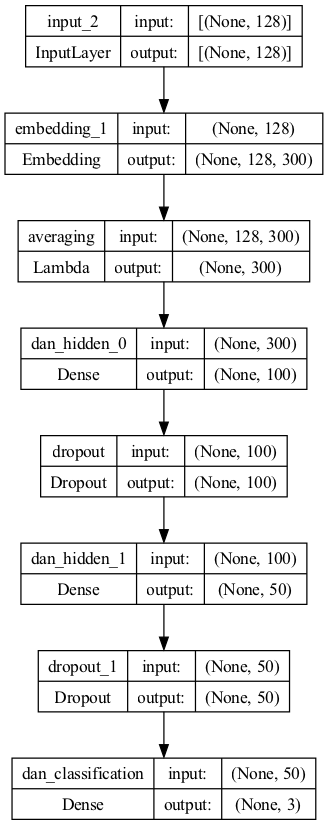

In [38]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5
num_classes = 3

dan_model = build_dan_model(num_classes, hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [39]:
dan_history = dan_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=20
                            )

Epoch 1/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9805 - accuracy: 0.5063 - val_loss: 0.9557 - val_accuracy: 0.5253
Epoch 2/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9413 - accuracy: 0.5530 - val_loss: 0.9393 - val_accuracy: 0.5354
Epoch 3/20
1135/1135 [==============================] - 3s 3ms/step - loss: 0.9272 - accuracy: 0.5622 - val_loss: 0.9297 - val_accuracy: 0.5473
Epoch 4/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9194 - accuracy: 0.5646 - val_loss: 0.9318 - val_accuracy: 0.5394
Epoch 5/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9138 - accuracy: 0.5671 - val_loss: 0.9211 - val_accuracy: 0.5493
Epoch 6/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9119 - accuracy: 0.5681 - val_loss: 0.9209 - val_accuracy: 0.5523
Epoch 7/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.9071 - accuracy: 0.5734 - val_loss: 0.9180 - val_accuracy:

In [40]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

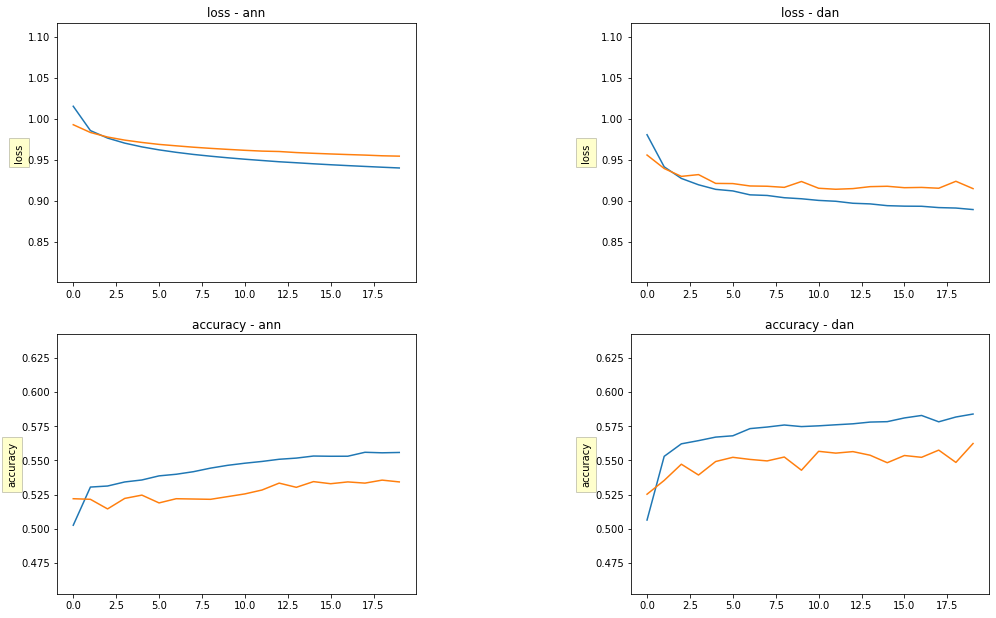

In [41]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          ann_history,
          dan_history,
          model_1_name='ann',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# CNN

In [42]:
def build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [43]:
# Now specify model hyperparameters and call the function to create a CNN model

num_classes = 3
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [44]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 128, 300)             1319460   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 126, 100)             90100     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 100)             120100    ['embedding_2[0][0]']   

In [45]:
cnn_history = cnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
1135/1135 [==============================] - 65s 56ms/step - loss: 0.9167 - accuracy: 0.5641 - val_loss: 0.9076 - val_accuracy: 0.5532
Epoch 2/5
1135/1135 [==============================] - 69s 61ms/step - loss: 0.8283 - accuracy: 0.6116 - val_loss: 0.9098 - val_accuracy: 0.5616
Epoch 3/5
1135/1135 [==============================] - 79s 69ms/step - loss: 0.7281 - accuracy: 0.6726 - val_loss: 0.9690 - val_accuracy: 0.5383
Epoch 4/5
1135/1135 [==============================] - 72s 64ms/step - loss: 0.6280 - accuracy: 0.7261 - val_loss: 1.0176 - val_accuracy: 0.5580
Epoch 5/5
1135/1135 [==============================] - 74s 66ms/step - loss: 0.5495 - accuracy: 0.7664 - val_loss: 1.0446 - val_accuracy: 0.5451


# RNN

In [46]:
def build_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=True):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

python(82356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


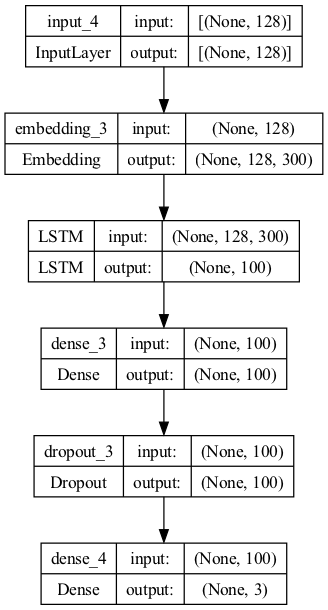

In [47]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3
rnn_model = build_rnn_model(num_classes,
                            rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [48]:
rnn_history = rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
1135/1135 [==============================] - 79s 68ms/step - loss: 1.0073 - accuracy: 0.4260 - val_loss: 1.0005 - val_accuracy: 0.4303
Epoch 2/5
1135/1135 [==============================] - 78s 69ms/step - loss: 1.0037 - accuracy: 0.4305 - val_loss: 1.0012 - val_accuracy: 0.4303
Epoch 3/5
1135/1135 [==============================] - 81s 71ms/step - loss: 1.0033 - accuracy: 0.4246 - val_loss: 1.0016 - val_accuracy: 0.4303
Epoch 4/5
1135/1135 [==============================] - 78s 69ms/step - loss: 1.0028 - accuracy: 0.4318 - val_loss: 1.0004 - val_accuracy: 0.4303
Epoch 5/5
1135/1135 [==============================] - 78s 69ms/step - loss: 1.0024 - accuracy: 0.4329 - val_loss: 1.0004 - val_accuracy: 0.4303


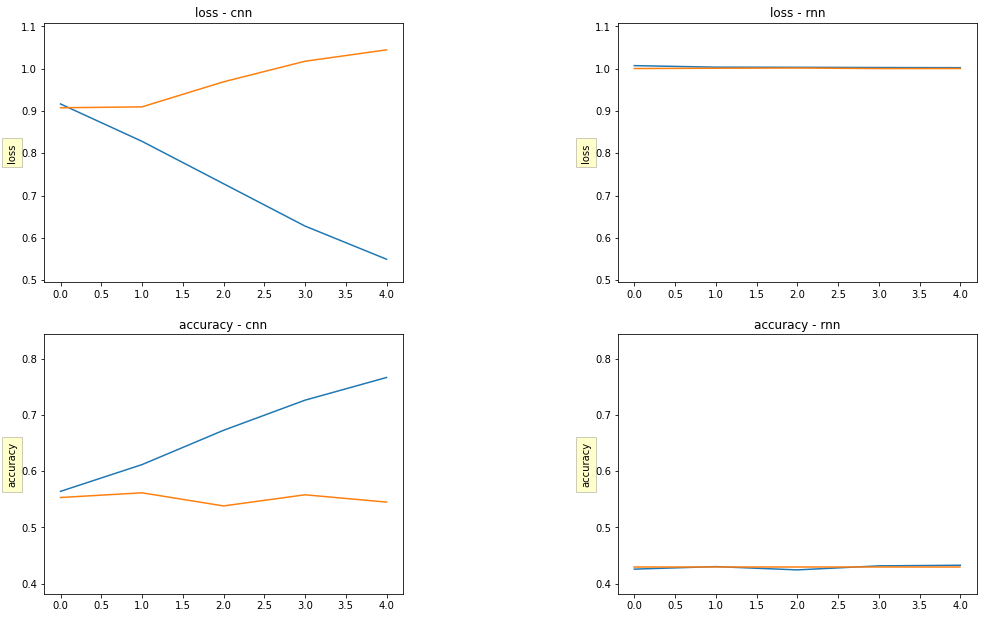

In [49]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          cnn_history, 
          rnn_history, 
          model_1_name='cnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# Stacked RNN

In [50]:
def build_stacked_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the stacked one
    #first one is called sequence output and change return_seq = True
    rnn_seq_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=True, return_state=False, name='LSTM1')\
        (rnn_embeddings)
    
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM2')\
        (rnn_seq_output) # calc the seq here
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

In [51]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3

stack_rnn_model = build_stacked_rnn_model(num_classes, 
                                          rnn_dim,
                                            dense_layer_dims,
                                            dropout_rate,
                                            embeddings_trainable=False)

In [52]:
stack_rnn_history = stack_rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
1135/1135 [==============================] - 147s 127ms/step - loss: 1.0065 - accuracy: 0.4317 - val_loss: 1.0005 - val_accuracy: 0.4303
Epoch 2/5
1135/1135 [==============================] - 134s 118ms/step - loss: 1.0037 - accuracy: 0.4291 - val_loss: 1.0015 - val_accuracy: 0.4303
Epoch 3/5
1135/1135 [==============================] - 133s 117ms/step - loss: 1.0026 - accuracy: 0.4344 - val_loss: 1.0007 - val_accuracy: 0.4303
Epoch 4/5
1135/1135 [==============================] - 132s 116ms/step - loss: 1.0029 - accuracy: 0.4268 - val_loss: 1.0005 - val_accuracy: 0.4303
Epoch 5/5
1135/1135 [==============================] - 133s 117ms/step - loss: 1.0029 - accuracy: 0.4270 - val_loss: 1.0009 - val_accuracy: 0.4303


# BiDirectional RNN

In [53]:
def build_bidirectional_rnn_model(num_classes, rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the Bidirectional one
    #first one is called sequence output and change return_seq = True
    rnn_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM1'))\
        (rnn_embeddings)
    
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(num_classes, activation='softmax')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  
                      metrics=['accuracy'])
    return rnn_model

In [54]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5
num_classes = 3

bi_rnn_model = build_bidirectional_rnn_model(num_classes,
                                             rnn_dim,
                                            dense_layer_dims,
                                            dropout_rate,
                                            embeddings_trainable=False)

In [55]:
bi_rnn_history = bi_rnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_valid_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
1135/1135 [==============================] - 126s 109ms/step - loss: 0.9254 - accuracy: 0.5608 - val_loss: 0.9148 - val_accuracy: 0.5493
Epoch 2/5
1135/1135 [==============================] - 125s 111ms/step - loss: 0.8873 - accuracy: 0.5838 - val_loss: 0.9178 - val_accuracy: 0.5561
Epoch 3/5
1135/1135 [==============================] - 127s 112ms/step - loss: 0.8649 - accuracy: 0.5971 - val_loss: 0.9264 - val_accuracy: 0.5569
Epoch 4/5
1135/1135 [==============================] - 127s 112ms/step - loss: 0.8455 - accuracy: 0.6036 - val_loss: 0.9363 - val_accuracy: 0.5446
Epoch 5/5
1135/1135 [==============================] - 130s 114ms/step - loss: 0.8200 - accuracy: 0.6170 - val_loss: 0.9458 - val_accuracy: 0.5466


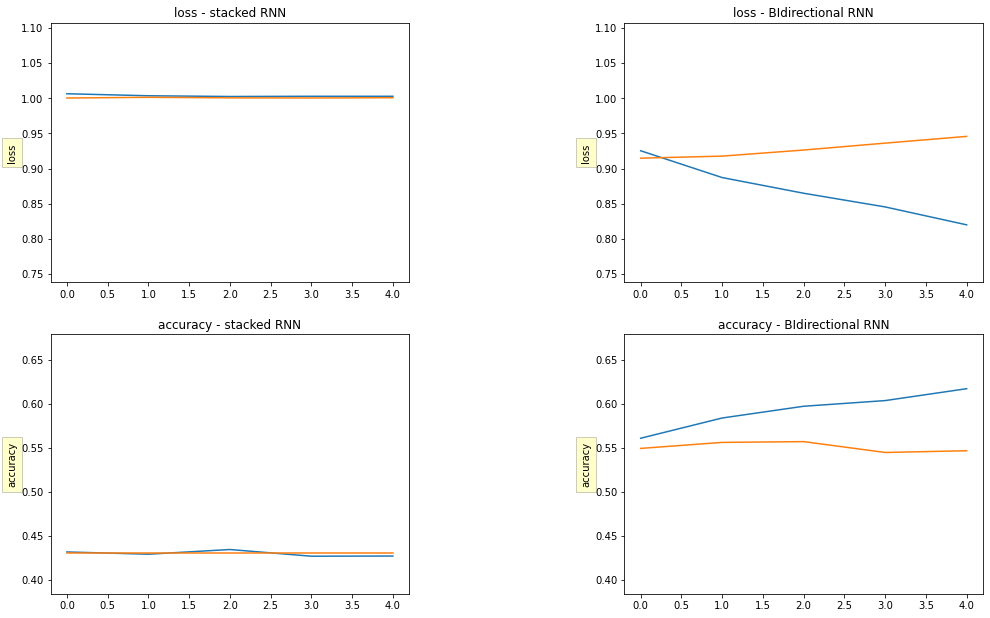

In [56]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          stack_rnn_history, 
          bi_rnn_history, 
          model_1_name='stacked RNN',
          model_2_name='BIdirectional RNN')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()